In [1]:
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2021-09-06 12:24:03.406669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-06 12:24:03.406770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
MODEL_PATH = "../models/finetuned_2_save_at_20.h5"
TEST_DATA_PATH = "../data/test.csv"
DATA_DIRECTORY = "../data/"
TEST_DATA_FILE = "test.csv"
TRAIN_DATA_FILE = "training.csv"
SAMPLE_SUBMISSION_FILE = "SampleSubmission.csv"
ID_LOOKUP_FILE = "IdLookupTable.csv"

In [3]:
def get_image_from_string(image_pixels_string):
    
    image_pixels_list = [int(point) for point in image_pixels_string.split(" ")]
    image_side = int(np.sqrt(len(image_pixels_list)))
    image = np.reshape(image_pixels_list, (image_side, image_side))
    image = np.stack([image, image, image], axis=2)
    
    return image

def display_image(image):
    
    plt.figure()
    plt.imshow(image.astype(np.uint8))
    
    return

def draw_keypoints(image, keypoints):
    
    for i in np.linspace(0, len(keypoints)-2, 15, dtype=int):
        if math.isnan(keypoints[i]) or math.isnan(keypoints[i+1]):
            continue
        if keypoints[i] < 0 or keypoints[i] > 95:
            continue
        if keypoints[i+1] < 0 or keypoints[i+1] > 95:
            continue
        image[int(keypoints[i+1]), int(keypoints[i])] = 255
        
    return image

In [4]:
def get_model(base_trainable=False):
    
    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(96, 96, 3))
    base_model.trainable = base_trainable
    
    inputs = tf.keras.Input(shape=(96, 96, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(30)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [5]:
model = get_model()

2021-09-06 12:24:10.256535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-06 12:24:10.256565: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-06 12:24:10.256589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ali-Latitude-E5470): /proc/driver/nvidia/version does not exist
2021-09-06 12:24:10.256820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model = tf.keras.models.load_model(MODEL_PATH)

In [7]:
test_df = pd.read_csv(TEST_DATA_PATH)

In [8]:
test_df

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...,...
1778,1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1779,1780,201 191 171 158 145 140 136 130 123 115 108 10...
1780,1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781,1782,104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...


In [9]:
# for index in range(len(test_df)):
#     if index == 10:
#         break
#     image_pixels_string = test_df["Image"][index]
#     image = get_image_from_string(image_pixels_string)
#     display_image(image)

In [10]:
test_images = []

for index in range(len(test_df)):
    test_images.append(get_image_from_string(test_df["Image"][index]).astype(float))

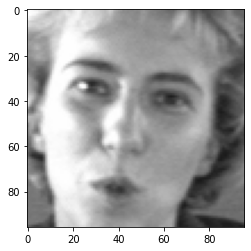

In [11]:
display_image(test_images[99])

In [12]:
test_images_tensor = tf.convert_to_tensor(test_images)

In [13]:
test_images_tensor.shape

TensorShape([1783, 96, 96, 3])

In [14]:
predictions = model.predict(test_images_tensor)

2021-09-06 12:24:50.243893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-06 12:24:50.264357: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499950000 Hz


In [21]:
random_indices = np.random.randint(0, len(test_images) + 1, 10)

In [31]:
random_indices

array([1180,  938,  633,  917,  393, 1462, 1004,  909,  324, 1434])

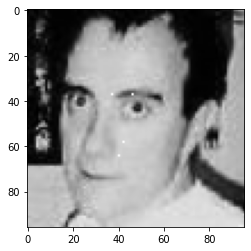

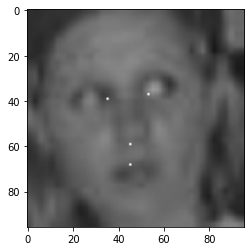

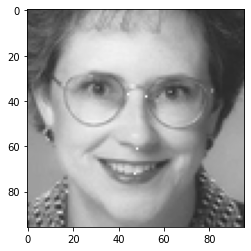

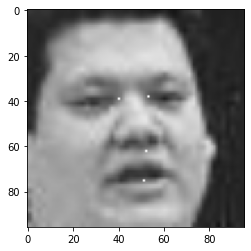

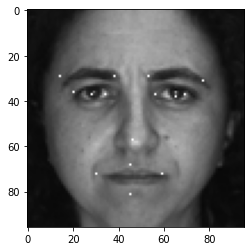

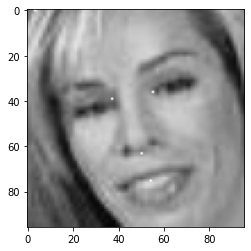

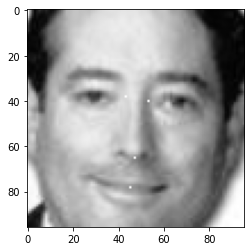

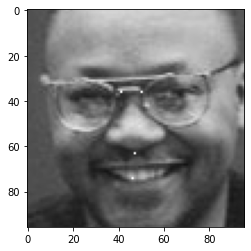

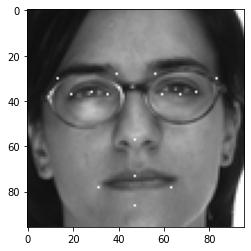

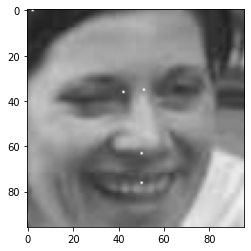

In [32]:
for index in random_indices:
    display_image(draw_keypoints(test_images[index].copy(), predictions[index]))

In [69]:
count = 0
for test_image, prediction in zip(test_images, predictions):
    count += 1
    if count == 50:
        break
    display_image(draw_keypoints(test_image.copy(), prediction))

In [62]:
predictions.shape

(1783, 30)

In [66]:
(1783 * 30)/2

26745.0

In [68]:
!ls ../data

IdLookupTable.csv  SampleSubmission.csv  test.csv  training.csv


In [24]:
id_lookup_df = pd.read_csv(DATA_DIRECTORY + ID_LOOKUP_FILE)

In [25]:
feature_names = np.array(id_lookup_df[id_lookup_df["ImageId"]==1]["FeatureName"].values)

In [26]:
feature_name_2_prediction_index = {feature_name: index for index, feature_name in enumerate(feature_names)}

In [102]:
images_ids = np.unique(id_lookup_df["ImageId"].values)

In [105]:
image_id = 1

In [108]:
required_features = id_lookup_df[id_lookup_df["ImageId"] == image_id]["FeatureName"].values

In [109]:
required_prediction_indices = [feature_name_2_prediction_index[feature_name] for feature_name in required_features]

In [112]:
predictions[0][required_prediction_indices]

array([61.59609 , 36.694588, 32.718456, 35.52936 , 56.772778, 37.224953,
       67.3179  , 37.200523, 38.892033, 37.19378 , 28.274818, 37.24233 ,
       54.556194, 28.30321 , 73.95293 , 29.728834, 41.528416, 28.288841,
       22.961218, 28.992188, 47.654236, 53.8401  , 59.456326, 76.793755,
       36.185406, 76.354164, 47.86641 , 71.86139 , 47.077934, 83.52289 ],
      dtype=float32)

In [125]:
locations = np.array([])

for index, image_id in enumerate(images_ids):
    required_features = id_lookup_df[id_lookup_df["ImageId"] == image_id]["FeatureName"].values
    required_prediction_indices = [feature_name_2_prediction_index[feature_name] for feature_name in required_features]
    required_predictions = predictions[0][required_prediction_indices]
    locations = np.append(locations, required_predictions)

In [127]:
len(locations)

27124

In [128]:
sample_submission_df = pd.read_csv(DATA_DIRECTORY + SAMPLE_SUBMISSION_FILE)

In [130]:
id_lookup_df["Location"] = locations

In [131]:
id_lookup_df

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,61.596088
1,2,1,left_eye_center_y,36.694588
2,3,1,right_eye_center_x,32.718456
3,4,1,right_eye_center_y,35.529362
4,5,1,left_eye_inner_corner_x,56.772778
...,...,...,...,...
27119,27120,1783,right_eye_center_y,35.529362
27120,27121,1783,nose_tip_x,47.654236
27121,27122,1783,nose_tip_y,53.840099
27122,27123,1783,mouth_center_bottom_lip_x,47.077934


In [133]:
submission_df = id_lookup_df[["RowId", "Location"]]

In [134]:
submission_df

,RowId,Location
0,1,61.596088
1,2,36.694588
2,3,32.718456
3,4,35.529362
4,5,56.772778
...,...,...
27119,27120,35.529362
27120,27121,47.654236
27121,27122,53.840099
27122,27123,47.077934


In [135]:
sample_submission_df

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [75]:
!ls ../data/

IdLookupTable.csv  SampleSubmission.csv  submission.csv  test.csv  training.csv


In [139]:
submission_df.to_csv("../data/submission.csv", index=False)

In [76]:
image_ids = range(0, len(test_images))

In [77]:
ff = []

for img_id in image_ids:
    f = id_lookup_df[id_lookup_df["ImageId"]==img_id]["FeatureName"].values
    ff.append(sorted(list(f)))

In [78]:
len(ff)

1783

In [79]:
ffu = np.unique(ff)

In [80]:
len(ffu)

22

In [81]:
for ii in ffu:
    print(len(ii))

0
28
30
26
28
24
28
26
28
26
26
28
20
26
22
24
26
24
20
8
6
18


In [37]:
id_lookup_df[id_lookup_df["ImageId"]==938]["FeatureName"].values

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype=object)

In [30]:
feature_names

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y',
       'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype=object)